In [25]:
import numpy as np
import pandas as pd
import os
import glob
import datetime as dt
from undaqTools import Daq, stat
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

# Load DAQ

In [39]:
daq = Daq()
daq.read('data/PID03/SH_PHD_MainRun_20200127113138.daq')

In [4]:
#Year-Month-Day Hour(24):Minute:Second:Microsecond (1:1000000)
print(dt.datetime.fromtimestamp(os.path.getctime('data/PID01/SH_PHD_MainRun_20200124110551.daq')).strftime('%Y-%m-%d %H:%M:%S:%f'))

2020-01-24 11:05:51:536467


In [5]:
daq.keys()

['SCC_Scenario_Date',
 'SCC_Eval_Window_SDLP',
 'VDS_Cruise_SetSpeed',
 'SCC_LDW_AlertNumber',
 'SCC_DynObj_Name',
 'AUX_CACC_Gap',
 'SCC_InitChassis_CG_Info_Ready',
 'CFS_TRANS_Crnk_Psh_Btn',
 'SCC_Eval_Window_Collisions',
 'VDS_ESP_ACTIV_FLAG',
 'SCC_AD_ISAT_HI_Final',
 'VDS_Veh_Heading',
 'SCC_Eval_SpeedSD',
 'SCC_Eval_Window_SpeedSD',
 'SCC_Lane_Disturb',
 'SCC_DynObj_RollPitch',
 'SCC_Brake_Control',
 'VDS_Tire_Rot_Vel',
 'VDS_Steering_Wheel_Angle',
 'VDS_Load_Torque',
 'SCC_LDW_StatusOnOff',
 'SCC_Replay_Event_Type',
 'SCC_Graphics_Wall_Clock_Time',
 'CIS_Headlights_On',
 'SCC_Glare_Obj_List_Size',
 'SCC_Collision_Count',
 'AUX_Info_Button',
 'CIS_Cruise_Control',
 'SCC_PrecipRate',
 'SCC_LKA_StatusOnOff',
 'VDS_ALF_State',
 'VDS_Chassis_CG_Ang_Vel',
 'SCC_Visual_Database',
 'SOP_Scenario_Input',
 'SCC_Drive_ID',
 'SCC_Eval_Event_Lane_Departures',
 'CFS_Accelerator_Pedal_Position',
 'SCC_Collision_List_Size',
 'SOP_Simulation_Time',
 'VDS_Veh_Dynamic_Pres',
 'SCC_Eval_Window_Lane

# Extract Timestamps

In [6]:
def get_timestamps(directory, save_location, file_name, **kwargs):
    '''
    Input:
        directory:
        save_location:
        file_name:
        **kwargs:
    Output:
    
    '''
    pid_list = []
    ts_list = []
    fname_list = []

    for dirpath, dirnames, files in os.walk(directory):
        for f in files:
            if f.endswith('.daq'):
                pid = dirpath.split('\\')[-1]
                timestamp = dt.datetime.fromtimestamp(os.path.getctime(os.path.join(dirpath,f))).strftime('%Y-%m-%d %H:%M:%S.%f')
                
                fname_list.append(f)
                ts_list.append(timestamp)
                pid_list.append(pid)
                
    data = {'PID':pid_list, 'file_name':fname_list, 'timestamp':ts_list}
    data = pd.DataFrame.from_dict(data)
    data.to_csv(os.path.join(save_location, file_name), **kwargs)
    
get_timestamps('data','data','PID_timestamp.csv', index=False)

In [52]:
df_timestamp = pd.read_csv('data/PID_timestamp.csv')

# DAQ to data frame

In [26]:
def daq_to_df(daq, elemlist, timestamps):
    elapsed_time = 'SCC_Graphics_Wall_Clock_Time'
    
    # Create datetime list
    file_name = ''.join(i[0] for i in np.array(daq['Run']))
    file_name2 = ''.join(i[0] for i in np.array(daq['RunInst']))
    file_name = file_name + '_' + file_name2 + '.daq'
    
    base_timestamp = dt.datetime.strptime(timestamps.loc[timestamps['file_name'] == file_name]['timestamp'].values[0], '%Y-%m-%d %H:%M:%S.%f')
    ms_diff = np.cumsum(np.diff(np.array(daq[elapsed_time]), n=1)[0,:])
    date_range = [base_timestamp + dt.timedelta(milliseconds=i) for i in ms_diff]
    date_range.insert(0,base_timestamp)
    
    # Find start frame and end frame as these are not 1-indexed
    start_frame = daq[elapsed_time].frames[0]
    end_frame = daq[elapsed_time].frames[-1]
    
    # Check to see if 'SCC_Grapihcs_Wall_Clock_Time' is in the elemlist, if so remove as this will always be added as elapsed time
    if elapsed_time in elemlist:
        elemlist.remove(elapsed_time)
    
    # Add elapsed time as first column of data list
    data_list = [np.array(daq[elapsed_time]).T - np.array(daq[elapsed_time])[0,0]]
    col_list = ['elapsed_time']
    
    for elem in elemlist:
        if daq[elem].isCSSDC():
            frames = daq[elem].frames - start_frame + 1 # make frames start at 1
            frames = np.concatenate((frames,[end_frame-start_frame+2]))
            frames = np.diff(frames, n=1)
            
            new_elem = np.repeat(np.array(daq[elem]).T, frames, axis=0)
            
            data_list.append(new_elem)
            
            for i in range(new_elem.shape[1]):
                col_list.append(elem + '_' + str(i))
        else:
            new_elem = np.array(daq[elem]).T
            
            data_list.append(new_elem)
            
            for i in range(new_elem.shape[1]):
                col_list.append(elem + '_' + str(i))
                
    data = np.concatenate(data_list, axis=1)

    df = pd.DataFrame(data=data, columns=col_list, index=date_range)
    return df

In [48]:
elemlist = ['SCC_LogStreams', 'CFS_Accelerator_Pedal_Position', 'CFS_Brake_Pedal_Force', 'CFS_Steering_Wheel_Angle_Rate','SCC_Graphics_Wall_Clock_Time', 'VDS_ACC_Gap']
# Thresholds from scenario: 
df = daq_to_df(daq, elemlist, df_timestamp)

In [88]:
df.head()

,elapsed_time,SCC_LogStreams_0,SCC_LogStreams_1,SCC_LogStreams_2,SCC_LogStreams_3,SCC_LogStreams_4,CFS_Accelerator_Pedal_Position_0,CFS_Brake_Pedal_Force_0,CFS_Steering_Wheel_Angle_Rate_0,VDS_ACC_Gap_0
2020-02-03 14:35:33.195990,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.04
2020-02-03 14:35:33.211990,16.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.04
2020-02-03 14:35:33.227990,32.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.04
2020-02-03 14:35:33.242990,47.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.04
2020-02-03 14:35:33.258990,63.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.04


# Extract Take-Over-Times

In [49]:
def extract_tot(df, action_map, pid):
    '''
    Input:
        df: numpy array with Tx6. 
            First column is markers for failure time, 
            second column is markers for driver response time, and the
            third column as the elapsed time in ms
            4,5,6 are the accel, brake, and steer data
        action_map: a dictionary of the action:threshold value
    Output:
        returns a tuple (a list of tot times, a list of tuples of the start and end time of the tot, list of tuples the order of responses)
    '''
    tot_times = []
    actions = ['accel', 'brake', 'steer']
    driver_response = []
    ts_list = []
    
    # PID, event #, acc gap, TOT, TS_Start, TS_End, response_1, response_2, response_3
    data = []
    
    
    df_numpy = df.values
    
    num_tot = int(np.max(df_numpy[:,0]))
    
    for i in range(num_tot):
        row = [pid,i]
        start_time = int(np.argwhere(df_numpy[:,0] == i+1)[0])        
        
        action_temp = []
        
        # Calculate first action
        for i, j in zip(actions, range(3,6)):
            try:
                action_temp.append(int(np.argwhere(df_numpy[start_time:start_time+600, j] > action_map[i])[0]))
            except:
                action_temp.append(9999)
        
        end_time = int(np.min(action_temp))
        
        # Dataframe
        row.append(df_numpy[start_time-60,-1]) # ACC Gap
        row.append((df_numpy[start_time+end_time,2] - df_numpy[start_time,2])/1000) # TOT
        row.append(df.index[start_time]) # start timestamp
        row.append(df.index[start_time+end_time]) # end timestamp
        for i in np.argsort(action_temp): # Record the driver reponse
            if action_temp[i] < 9999:
                row.append(actions[i])
            else:
                row.append("None")
        data.append(row)
        
        # Create dataframe
    df_data = pd.DataFrame(data, columns = ['PID','event_#','ACC_gap','TOT','TS_start','TS_end','response_1','response_2','response_3'])
        
    return df_data

In [50]:
extract_tot(df[['SCC_LogStreams_1', 'SCC_LogStreams_2','elapsed_time', 'CFS_Accelerator_Pedal_Position_0', 'CFS_Brake_Pedal_Force_0', 'CFS_Steering_Wheel_Angle_Rate_0', 'VDS_ACC_Gap_0']], action_map = {'accel':.1, 'brake':10, 'steer':5}, pid="PID03")

,PID,event_#,ACC_gap,TOT,TS_start,TS_end,response_1,response_2,response_3
0,PID03,0,1.04,2.219,2020-01-27 11:33:57.413226,2020-01-27 11:33:59.632226,accel,steer,brake
1,PID03,1,3.04,1.297,2020-01-27 11:35:42.413226,2020-01-27 11:35:43.710226,steer,accel,None
2,PID03,2,1.04,1.438,2020-01-27 11:37:27.413226,2020-01-27 11:37:28.851226,steer,accel,brake
3,PID03,3,2.04,2.031,2020-01-27 11:39:12.413226,2020-01-27 11:39:14.444226,steer,accel,None
4,PID03,4,1.04,1.235,2020-01-27 11:40:57.413226,2020-01-27 11:40:58.648226,steer,accel,None
5,PID03,5,3.04,1.266,2020-01-27 11:42:42.413226,2020-01-27 11:42:43.679226,steer,accel,None
6,PID03,6,3.04,1.313,2020-01-27 11:44:27.413226,2020-01-27 11:44:28.726226,steer,accel,None
7,PID03,7,2.04,1.188,2020-01-27 11:46:12.413226,2020-01-27 11:46:13.601226,steer,accel,None
8,PID03,8,2.04,1.188,2020-01-27 11:47:57.413226,2020-01-27 11:47:58.601226,steer,accel,None
9,PID03,9,1.04,1.188,2020-01-27 11:49:42.413226,2020-01-27 11:49:43.601226,steer,brake,accel


# Batch Process Files

In [54]:
# Extract all TOT from daq files in the data folder
# Change your directory to the directory where the data is being stored
# os.chdir("/mydir")
elemlist = ['SCC_LogStreams', 'CFS_Accelerator_Pedal_Position', 'CFS_Brake_Pedal_Force', 'CFS_Steering_Wheel_Angle_Rate','SCC_Graphics_Wall_Clock_Time', 'VDS_ACC_Gap']
action_map = {'accel':.1, 'brake':10, 'steer':5}
cols = ['SCC_LogStreams_1', 'SCC_LogStreams_2','elapsed_time', 'CFS_Accelerator_Pedal_Position_0', 'CFS_Brake_Pedal_Force_0', 'CFS_Steering_Wheel_Angle_Rate_0', 'VDS_ACC_Gap_0']

df_list = []

for fname in tqdm(glob.glob('data\*\*.daq')):
    daq = Daq()
    daq.read(fname)
    
    file_name = ''.join(i[0] for i in np.array(daq['Run']))
    file_name2 = ''.join(i[0] for i in np.array(daq['RunInst']))
    file_name = file_name + '_' + file_name2 + '.daq'
    pid = df_timestamp.loc[df_timestamp['file_name'] == file_name]['PID'].values[0]
    
    df = daq_to_df(daq, elemlist, df_timestamp)
    df_list.append(extract_tot(df[cols], action_map = action_map, pid = pid))

    

In [55]:
df_results = pd.concat(df_list)
df_results.head()

,PID,event_#,ACC_gap,TOT,TS_start,TS_end,response_1,response_2,response_3
0,PID01,0,1.04,1.781,2020-01-24 11:08:23.349467,2020-01-24 11:08:25.130467,steer,accel,None
1,PID01,1,1.04,1.719,2020-01-24 11:10:08.349467,2020-01-24 11:10:10.068467,steer,accel,None
2,PID01,2,1.04,1.734,2020-01-24 11:11:53.349467,2020-01-24 11:11:55.083467,accel,steer,None
3,PID01,3,2.04,1.641,2020-01-24 11:13:38.349467,2020-01-24 11:13:39.990467,accel,steer,None
4,PID01,4,2.04,1.594,2020-01-24 11:15:23.349467,2020-01-24 11:15:24.943467,steer,accel,None


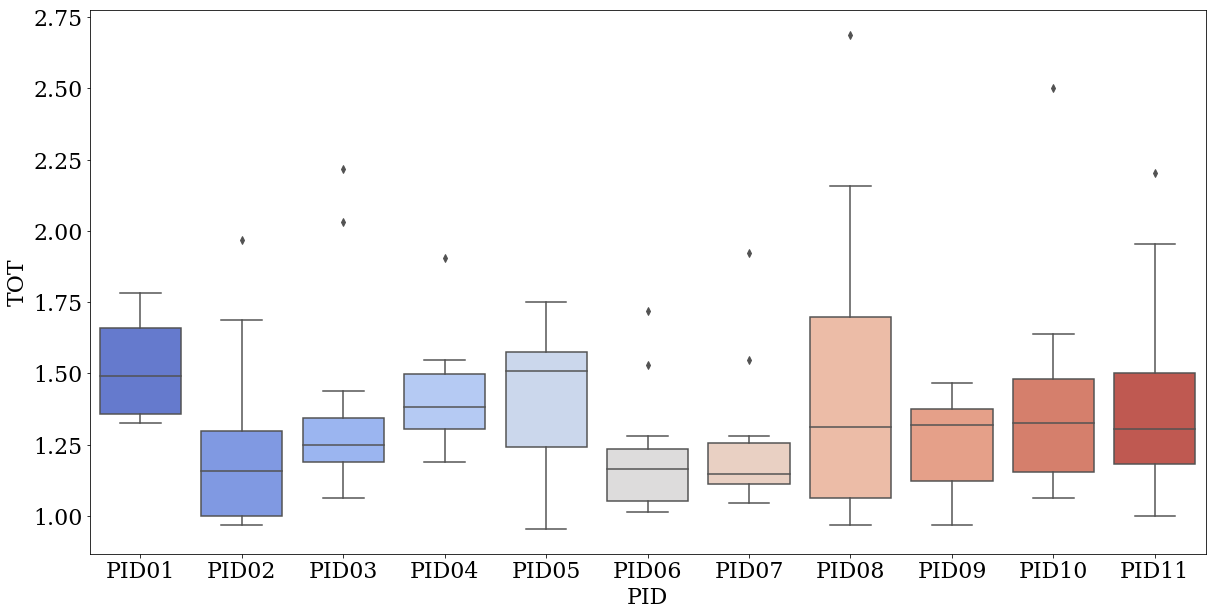

In [96]:
# TOT Boxplot
plt.figure(figsize=(20,10))
fig = sns.boxplot(x="PID", y="TOT", palette=sns.color_palette("coolwarm", 11), data=df_results)
plt.show()

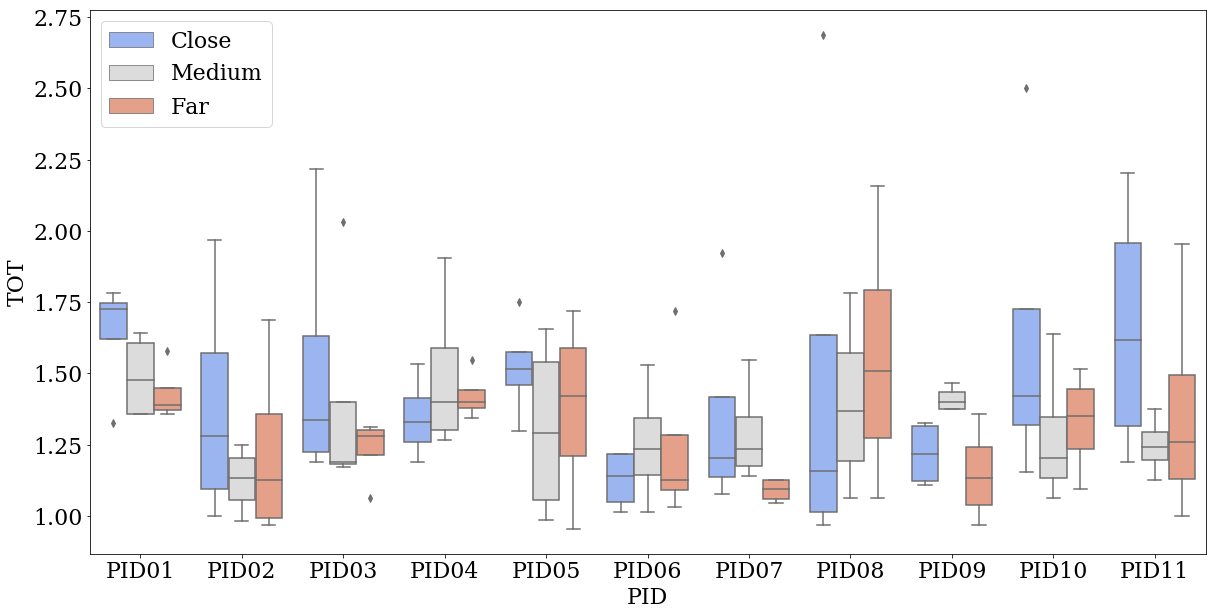

In [95]:
# TOT Boxplot grouped by acc gap
plt.figure(figsize=(20,10))
fig = sns.boxplot(x="PID", y="TOT", hue="ACC_gap", palette=sns.color_palette("coolwarm", 3), data=df_results)
handles, labels = fig.get_legend_handles_labels()
fig.legend(handles, ['Close','Medium','Far'])
plt.show()

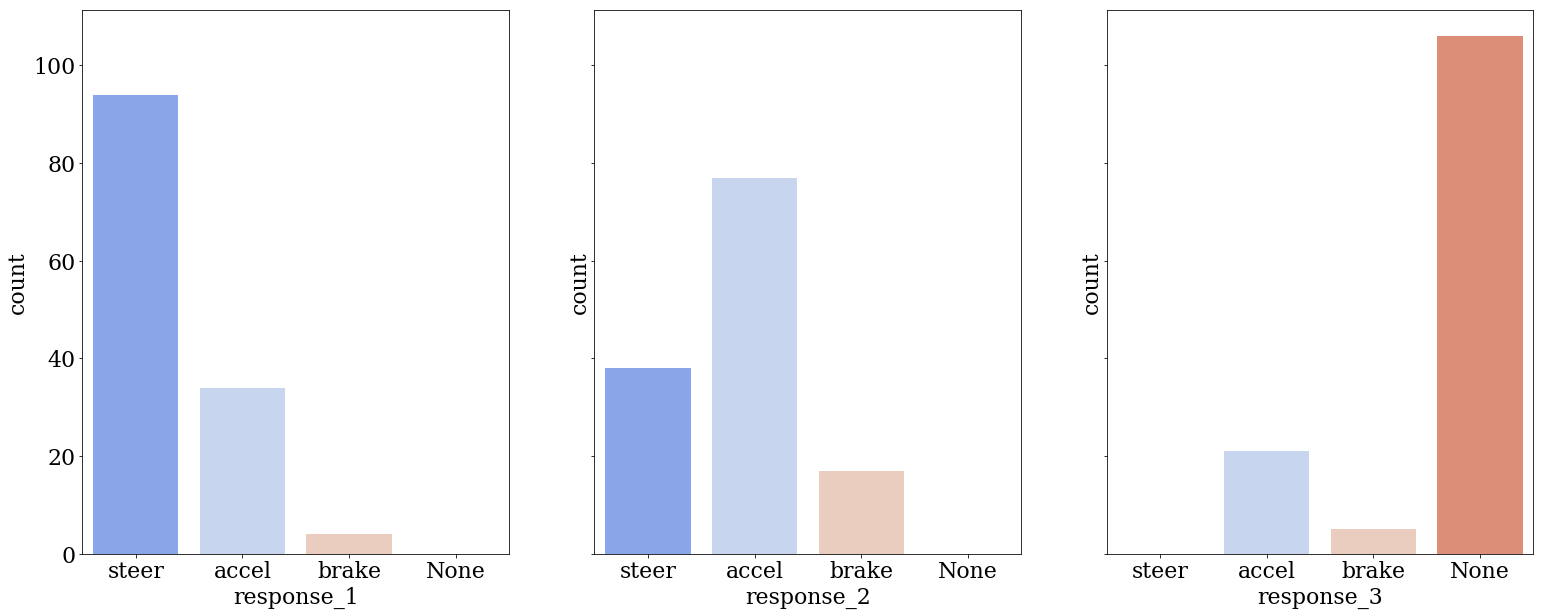

In [94]:
# Count plot of participant responses
f, axes = plt.subplots(1, 3, figsize=(26, 10), sharex=True, sharey=True)
sns.countplot(x="response_1", order=["steer","accel","brake","None"], palette=sns.color_palette("coolwarm", 4), data=df_results, ax = axes[0])
sns.countplot(x="response_2", order=["steer","accel","brake","None"], palette=sns.color_palette("coolwarm", 4), data=df_results, ax = axes[1])
sns.countplot(x="response_3", order=["steer","accel","brake","None"], palette=sns.color_palette("coolwarm", 4), data=df_results, ax = axes[2])
plt.show()

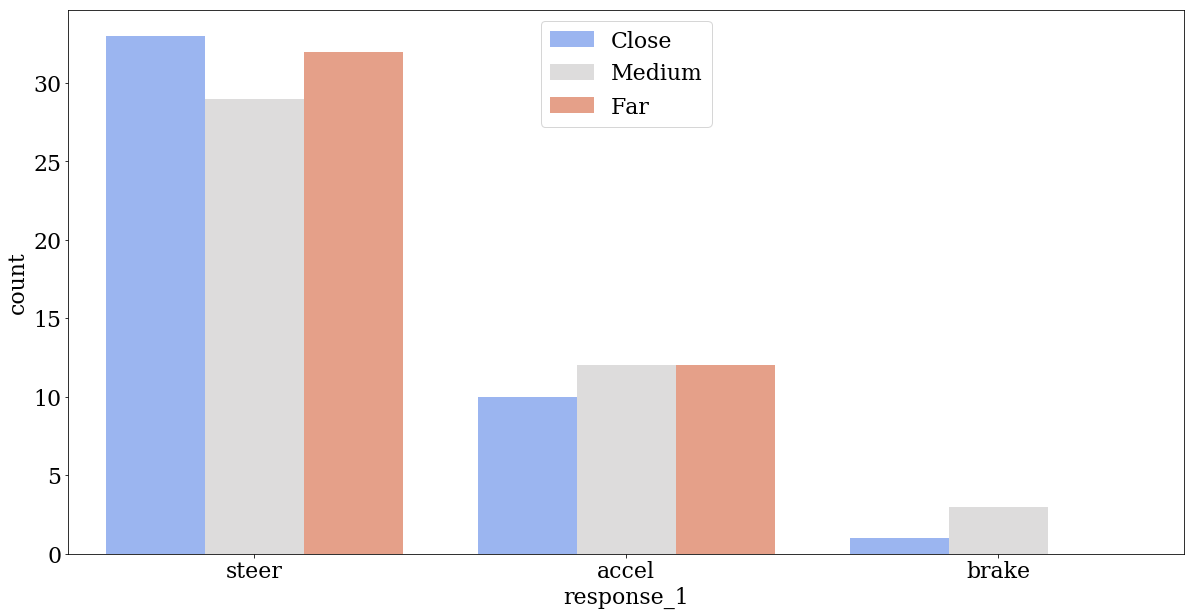

In [93]:
# Count plot of participant responses
plt.figure(figsize=(20,10))
fig = sns.countplot(x="response_1", hue = 'ACC_gap', palette=sns.color_palette("coolwarm", 3), data=df_results)
handles, labels = fig.get_legend_handles_labels()
fig.legend(handles, ['Close','Medium','Far'])
plt.show()